In [132]:
#Environment
import numpy as np
from enum import Enum

class Team(Enum):
    CT = 0
    T = 1
    
class Direction(Enum):
    UP = 1
    DOWN = 2
    LEFT = 3
    RIGHT = 4

class Board:
    def __init__(self):
        self.size = 20
        self.players = [] #Define a list of players on the map
        self.boxes = [] #Define a list for the boxes on the map
        self.observation = np.zeros((2, 2*self.size, 2*self.size))
        self.timer = 10000
        self.bomb = None
        self.defused = False
    
    def init_observation(self):
        for i in range(int(self.size*2)):
            t_x = i - self.size
            for j in range(int(self.size*2)):
                t_y = j - self.size
                for box in self.boxes:
                    if box.in_box(t_x, t_y):
                        self.observation[0][j][i] = 1
                        break

                for player in self.players:
                    if t_x == player.x and t_y == player.y:
                        self.observation[0][j][i] = 1
                        break
    
    def update_observation(self): #Boxes are stationary and so you do not need to update this
        for i in range(int(self.size*2)):
            t_x = i - self.size
            for j in range(int(self.size*2)):
                t_y = j - self.size
                for player in self.players:
                    if t_x == player.x and t_y == player.y:
                        self.observation[0][j][i] = 1
                        break
    def in_bombsite(self, objectx, objecty):
        if objectx <= 5 and objectx >= -5:
            if objecty <= 5 and objecty >= -5:
                return True
        return False
    
    def add_player(self, player):
        self.players.append(player)
    
    def add_box(self, box):
        self.boxes.append(box)
    
    def in_board(self, objectx, objecty):
        if objectx <= self.size and objectx >= -self.size:
            if objecty <= self.size and objecty >= -self.size:
                return True
        return False
    
class Box:
    def __init__(self, size, centerX, centerY, board, passable=False):
        self.size = size
        self.x = centerX
        self.y = centerY
        self.board = board
        self.passable = passable
        self.board.add_box(self)
        
    
    def in_box(self, objectx, objecty):
        if not self.passable:
            if objectx <= self.x + self.size/2 and objectx >= self.x - self.size/2:
                if objecty <= self.y + self.size/2 and objecty >= self.y - self.size/2:
                    return True
        return False
        
        

class Weapon:
    def __init__(self, damage, rate, clip, speed, range):
        self.damage = damage 
        self.rate = rate
        self.clip = clip
        self.speed = speed
        self.range = range
    
class Player:
    def __init__(self, centerX, centerY, team, weapon, view, board):
        self.size = 1
        self.x = centerX
        self.y = centerY 
        self.team = team #what team are they on
        self.weapon = weapon #What weapon will be equipped
        self.view = view #0 - 2pi.. where they are looking
        self.hp = 100
        self.board = board #define what map the player is on 
        self.board.add_player(self)
        self.fov = np.deg2rad(110) #The player's field of view
        self.bomb = False
        self.smoke = True
        if team == Team.T:
            self.bomb = True
    
    def view_mask(self): #return a mask of what pixels the player can see(1 where you can view and 0 where you cannot)
        view_width = 3 #how many units wide their view is
        view_length = 40 #how far they can see
        mask = np.zeros((self.board.size*2, self.board.size*2))
        
        perp_view = self.view + np.deg2rad(90)
        for k in range(view_width):
            offsetx = (k - 1)*np.cos(perp_view)
            offsety = (k - 1)*np.sin(perp_view)
            
            for t in range(view_length):
                rise = t*np.sin(self.view)
                run = t*np.cos(self.view)
                
                viewx = int(offsetx + run + self.x) + 20
                viewy = int(offsety + rise + self.y) + 20
                
                if viewx >= 0 and viewx <= 39:
                    if viewy >= 0 and viewy <= 39:
                        if self.board.observation[0][viewy][viewx] == 1: #There is a box on this pixel
                            break #Don't look any further!
                        mask[viewy][viewx] = 1
        
        return mask  
    
    def move(self, direction): #Move players position
        if self.hp > 0:
            tempx = self.x
            tempy = self.y
            
            if direction == Direction.UP:
                self.y += self.weapon.speed
            elif direction == Direction.DOWN:
                self.y -= self.weapon.speed
            elif direction == Direction.LEFT:
                self.x -= self.weapon.speed
            elif direction == Direction.RIGHT:
                self.x += self.weapon.speed
            
            for box in self.board.boxes: #Check movement collisions with boxes
                if box.in_box(self.x, self.y):
                    self.x = tempx
                    self.y = tempy
            
            if not self.board.in_board(self.x, self.y):
                self.x = tempx
                self.y = tempy
                    
                    
    
    def set_view(self, new_view):
        self.view = new_view
    
    def plant(self): #Plant the bomb
        if self.bomb: #If you have the bomb
            if self.board.in_bombsite(self.x, self.y): #If you are in the bombsite
                box = Box(0.5, self.x, self.y, self.board, passable=True) #Create a box of 0.5 at ur location
                self.board.bomb = box
                self.bomb = False
                return True
        return False
    
    def defuse(self):
        if not self.bomb and self.team == Team.CT:
            if self.board.bomb is not None:
                if self.board.bomb.in_box(self.x, self.y):
                    self.board.defused = True
                    return True
        return False
    
    def fire_smoke(self):
        if self.smoke: #If a smoke is in your inventory
            #smoke has range of 15
            smokeX = 15 * np.cos(self.view) + self.x
            smokeY = 15 * np.sin(self.view) + self.y
            smoke = Box(5, smokeX, smokeY, self.board, passable=True)
            self.smoke = False
                    
    
    def fire(self): #Fire your weapon
        if self.hp > 0 and self.weapon.clip > 0:
            self.weapon.clip = self.weapon.clip - 1
            vectX = np.cos(self.view)
            vectY = np.sin(self.view)

            for i in range(len(self.board.players)):
                player = self.board.players[i]

                if player != self:
                    Y = player.y - self.y
                    X = player.x - self.x
                    scalar = (X * vectX + Y * vectY)/(np.square(vectX) + np.square(vectY))
                    if scalar >= 0:
                        projX = scalar * vectX
                        projY = scalar * vectY
                        dist = np.square(Y - projY) + np.square(X - projX)
                        if dist <= np.square(2.0): #If our weapon has hit
                            cancel = False
                            for j in range(len(self.board.boxes)):
                                box = self.board.boxes[j]
                                if not box.passable:
                                    for k in range(10):
                                        bx = (k/10)*scalar * vectX + self.x
                                        by = (k/10)*scalar * vectY + self.y
                                        if box.in_box(bx, by):
                                            cancel = True
                                            break
                                if cancel:
                                    break
                            if not cancel:
                                player.hp -= self.weapon.damage
                                self.board.players[i] = player

In [2]:
#Animations to review demo of game
def update_plot(t, offset, color, ammo, scat):
    scat.set_offsets(offset[t])
    counts[0].set_text(f"Terrorist HP: {color[t][0]/2.56}")
    counts[1].set_text(f"AK ammo: {ammo[t][0]}/30")
    counts[2].set_text(f"Counter-Terrorist HP: {color[t][1]/2.56}")
    counts[3].set_text(f"AWP ammo: {ammo[t][1]}/10")
    return scat

In [155]:
#Create 1v1 NN
import keras
import numpy as np

from keras.models import Model
from keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, MaxPooling2D, AveragePooling2D, Concatenate, Dropout, AlphaDropout
from keras.layers import GlobalAveragePooling2D, Multiply, Permute, Reshape
from keras.optimizers import SGD
from keras.initializers import glorot_uniform
from keras.regularizers import l1, l2
from keras import backend as K

lambd = 0.001 #L2 regularization

def stem(X, filters, stage="stem", size=3):
    stem = Conv2D(filters=filters, kernel_size=(size,size), strides=(1,1), padding='same', data_format='channels_last', 
                  name='Conv_' + stage, kernel_initializer=glorot_uniform(), kernel_regularizer=l2(lambd))(X)
    stem = Activation('relu')(stem)
    return stem

def res_block(X, filters, block, size=3):
    res = Conv2D(filters=filters, kernel_size=(size,size), strides=(1,1), padding='same', data_format='channels_last', 
                name='res_block1_' + block, kernel_initializer=glorot_uniform(), kernel_regularizer=l2(lambd))(X)
    res = Activation('relu')(res)
    res = Conv2D(filters=filters, kernel_size=(size,size), strides=(1,1), padding='same', data_format='channels_last', 
                name='res_block2_' + block, kernel_initializer=glorot_uniform(), kernel_regularizer=l2(lambd))(res)
    
    X = Add()([X, res])
    X = Activation('relu')(X)
    return X

def create_model(filters, resblocks=5):
    image = Input(shape=(40, 40, 25)) #Masked images of last 10 board frames + 4 planes of info
    
    #Stem for our resnet
    X = stem(image, filters)
    
    #Resnet
    for i in range(resblocks):
        X = res_block(X, filters, str(i + 1))
    
    #Create latent representation
    latent = stem(X, 1, stage="latent", size=1)
    latent = Flatten()(latent)
    latent = Dense(50, activation="sigmoid", name="latentspace", kernel_initializer=glorot_uniform(),
                kernel_regularizer = l2(lambd))(latent)
    
    #Create state -> hidden state model
    fmodel = Model(inputs=image, outputs=latent)
    
    #Create policy for player 1 [Fire, Left, Right, Up, Down, Plant/Defuse] x [-90, -45, -27.5, -13.75, 0 .... 90] = 63
    p = Dense(63, activation="softmax", name="fcPolicy1", kernel_initializer=glorot_uniform(),
                kernel_regularizer = l2(lambd), input_shape=(50,))
    
    #Create value function for actor critic
    v = Dense(1, activation="tanh", name="fcValue", kernel_initializer=glorot_uniform(),
                kernel_regularizer = l2(lambd), input_shape=(50,))
    
    #Create hidden state -> policy/value model
    prev_latent = Input(shape=(50,))
    pol = p(prev_latent)
    val = v(prev_latent)
    gmodel = Model(inputs=prev_latent, outputs=[pol, val]) 
    
    #Create full model
    policy1 = p(latent)
    value = v(latent)
    model = Model(inputs=image, outputs=[policy1, value])
    
    #Create hidden state -> hidden state model (MCTS in LATENT SPACE)
    p_latent = Input(shape=(50,))
    new_policy = Input(shape=(63,))
    concat_input = Concatenate(axis=-1)([new_policy, p_latent])
    new_latent = Dense(50, activation="sigmoid", name="new_latent", kernel_initializer=glorot_uniform(),
                kernel_regularizer = l2(lambd))(concat_input)
    hmodel = Model(inputs=[p_latent, new_policy], outputs=new_latent)
    
    
    #Create updates for h model
    true_latent = K.placeholder(shape=(None, 50), name="truelatent")
    latent_MSE = K.sum(K.square(true_latent - new_latent), axis=1)
    L_h = K.mean(latent_MSE)
    
    opt_h = keras.optimizers.Adam(1e-4)
    updates_h = opt_h.get_updates(params=hmodel.trainable_weights, loss=L_h)
    train_fn_h = K.function(inputs=[hmodel.input[0], hmodel.input[1], true_latent],
                           outputs=[L_h], updates=updates_h)
    
    
    #Online Learning training function... updates the the full, f, g models
    p1 = K.clip(policy1, K.epsilon(), 1)
    
    #placeholder variables for PPO algorithm
    target = K.placeholder(shape=(None,1), name="target_value")
    expert = K.placeholder(shape=(None,63), name="expert_policy")
    expert = K.clip(expert,K.epsilon(), 1)
    
    
    adv = K.placeholder(shape=(None,1), name="adv")
    action =  K.placeholder(shape=(None,63), name="action")
    
    
    MSE = K.sum(K.square(target-value), axis=1)
    
    r = K.sum(action*p1/expert, axis=1)
    Lclip = K.minimum(r*adv, K.clip(r, 0.8, 1.2)*adv)
    entropy = K.sum(p1 * K.log(p1), axis=1)
    
    loss = -K.mean(Lclip) + K.mean(MSE) + 0.0001*K.mean(entropy)
    
    c1_print = -K.mean(Lclip)
    v_print = K.mean(MSE)
    e_print = 0.0001*K.mean(entropy)
    
    #optimizer
    opt = keras.optimizers.Adam(1e-4)
    updates = opt.get_updates(params=model.trainable_weights, loss=loss)
    train_fn = K.function(inputs=[model.input, target, expert, adv, action], 
                          outputs=[c1_print, v_print, e_print], updates=updates)
    
    return model, fmodel, gmodel, hmodel, train_fn, train_fn_h

In [47]:
def to_Direction(action_policy, temp=1.0):
    size = 63
    onehot = np.zeros((size,))
    action_policy = np.clip(action_policy, 1e-7, 1)
    action_policy = np.power(action_policy, 1/temp)
    probs = np.squeeze(action_policy/np.sum(action_policy))
    choice = np.random.choice(size, p=probs)
    onehot[choice] = 1
    action = -1
    view_angle = 0 
    
    if choice <= 8:
        action = -1
    elif choice <= 17:
        action = Direction.UP
    elif choice <= 26:
        action = Direction.DOWN
    elif choice <= 35:
        action = Direction.LEFT
    elif choice <= 44:
        action = Direction.RIGHT
    elif choice <= 53:
        action = -2
    elif choice <= 62:
        action = -3
    
    if choice % size == 0:
        view_angle = np.deg2rad(-90)
    elif choice % size == 1:
        view_angle = np.deg2rad(-45)
    elif choice % size == 2:
        view_angle = np.deg2rad(-27.5)
    elif choice % size == 3:
        view_angle = np.deg2rad(-13.75)
    elif choice % size == 4:
        view_angle = np.deg2rad(0)
    elif choice % size == 5:
        view_angle = np.deg2rad(13.75)
    elif choice % size == 6:
        view_angle = np.deg2rad(27.5)
    elif choice % size == 7:
        view_angle = np.deg2rad(45)
    elif choice % size == 8:
        view_angle = np.deg2rad(90)
    
    return action, view_angle, onehot
        

def data_to_planes(data, frames_array):
    hp = data[0]
    wep = data[1]
    time = data[2]
    team = data[3]
    ammo = data[4]/30
    
    hp_plane = np.full((1, 40, 40, 1), hp)
    ammo_plane = np.full((1, 40, 40, 1), ammo)
    wep_plane = np.full((1, 40, 40, 1), wep)
    time_plane = np.full((1, 40, 40, 1), time)
    team_plane = np.full((1, 40, 40, 1), team)
    
    
    frames_array = np.reshape(np.array(frames_array), [-1, 40, 40, 20])
    
    frames_array = np.concatenate((frames_array, hp_plane), axis=-1)
    frames_array = np.concatenate((frames_array, ammo_plane), axis=-1)
    frames_array = np.concatenate((frames_array, wep_plane), axis=-1)
    frames_array = np.concatenate((frames_array, time_plane), axis=-1)
    frames_array = np.concatenate((frames_array, team_plane), axis=-1)
    
    return frames_array
    

In [48]:
#This cell will implement MCTS so that we may use it to create an expert policy
def muMCTS(observation, turn, f_model, g_model, h_model, simulations=10000):
    if simulations == 0:
        hidden_state = f_model.predict(observation)
        policy, value = g_model.predict(hidden_state)
        return policy, value
    hidden_state = f_model.predict(observation)
    policy, _ = g_model.predict(hidden_state)
    root = init_root(hidden_state, policy, turn)

    for i in range(simulations):
        #print("Simulation: ", i)
        leaf_parent, state, action = root.leaf()
        #Create action one_hot
        action_onehot = np.zeros((1,63))
        action_onehot[0][action] = 1
        new_state = h_model.predict([state, action_onehot]) #Estimate hidden state
        policy, value = g_model.predict(new_state) #Get prediction from hidden state
        leaf_parent.expand_backup(action, new_state, policy, np.squeeze(value))

    return root.child_plays/np.sum(root.child_plays), np.mean(root.child_Q())

def init_root(hidden_state, policy, turn): #Handle root case
    root = Node(None, 0, hidden_state, policy, turn)
    return root

class Node:
    def __init__(self, parent, index, state, policy, turn): #On init we need to define the parent and the index the node is in the parent child array
        self.parent = parent
        self.index = index
        self.turn = turn #Boolean to switch our pUCT conditions
        self.policy = policy
        self.state = state

        self.child_plays = np.zeros([63], dtype=np.int32) #Keep track of how many times our children have played
        self.child_values = np.zeros([63], dtype=np.float32) #Keep track of the sum of q values

        self.children = [None]*63 #A list of children, there will 1924 of them.. no python chess to tell us less children

    def child_Q(self): #return average Q-values
        return self.child_values / (1 + self.child_plays)

    def child_U(self): #return puct bound
        #DEFINE HYPERPARAMETERS HERE
        c1 = 1.2
        c2 = 19652

        #Define sum of plays among the children
        total_plays = np.sum(self.child_plays)

        u = (c1 + np.log((total_plays + c2 + 1)/c2)) * np.sqrt(total_plays + 1) / (1 + self.child_plays)
        return self.policy * u

    def pUCT_child(self): #Returns state action pair (s', a)
        #print("calc puct")
        if self.turn: #CT
            child_index = np.argmax(self.child_Q() + self.child_U())
            return self.children[child_index], child_index
        else: #T
            child_index = np.argmin(self.child_Q() - self.child_U())
            return self.children[child_index], child_index

    def leaf(self, depth_max=10):
        #print("finding leaf")
        current = self
        parent = self
        depth = 0
        while current is not None and depth <= depth_max:
            parent = current
            current, action = self.pUCT_child()
            depth += 1
        return parent, parent.state, action #Action must be converted to one-hot or other formatting in search function

    def expand_backup(self, index, new_state, policy, value): #Create a child at index with state and policy
        #print("expanding")
        child = Node(self, index, new_state, policy, self.turn) #Counterfactual regret
        self.children[index] = child
        self.child_values[index] = value
        self.child_plays[index] += 1
        self.backup(value)

    def backup(self, value):
        #print("backing")
        current = self
        while current.parent != None:
            current.parent.child_values[self.index] += value
            current.parent.child_plays[self.index] += 1
            current = current.parent

In [40]:
model, fmodel, gmodel, hmodel, trainfn, trainh = create_model(32, resblocks=2)

In [166]:
def simulate_game(f_model, g_model, h_model, frames=600, tnodes=0, ctnodes=0, verbose=False):
    ak = Weapon(50, 1, 30, 2, 100)
    awp = Weapon(100, 1, 10, 1, 100)
    Map = Board()
    t_spawn = np.random.rand()*40 - 20
    ct_spawn = np.random.rand()*40 - 20
    t = Player(t_spawn, 16, Team.T, ak, 0, Map)
    ct = Player(ct_spawn, -16, Team.CT, awp, 0, Map)

    box1 = Box(10, -7.5, -10, Map)
    box2 = Box(10, 13.5, -10, Map)
    box3 = Box(10, -10, 10, Map)
    box4 = Box(10, 10, 10, Map)
    
    Map.init_observation()
    T_frames = [] #Will hold the last 10 frames
    CT_frames = [] #Will hold the last 10 frames
    
    mask_T = t.view_mask()
    obs_T = Map.observation
    obs_T[0] = obs_T[1] * mask_T
    obs_T[1] = obs_T[1] * mask_T
    
    mask_CT = ct.view_mask()
    obs_CT = Map.observation
    obs_CT[0] = obs_CT[1] * mask_CT
    obs_CT[1] = obs_CT[1] * mask_CT
    
    #[model.input, target, expert, action_t, old_latent, new_latent]
    model_image = []
    target = []
    advantages = []
    action = []
    expert = []
    
    
    
    action_t = []
    old_latent = []
    new_latent = []
    
    powers = [] #This will hold information for the advantage calc
    turn = []
    
    for _ in range(10): #Initialize list to have 10 frames
        T_frames.append(obs_T)
        CT_frames.append(obs_CT)
    
    #Data to animate game later
    offsets = np.zeros((frames, 4, 2))
    colors = np.zeros((frames, 2))
    ammo  = np.zeros((frames, 2))
    
    time_done = True
    ct_won = True
    final_time = 0
    
    #Set up current data to be sent to our NN
    T_data = [t.hp/100, 0.0, 1.0, 0, t.weapon.clip]
    T_image = data_to_planes(T_data, T_frames)
    T_image = np.array(T_image)
    T_image = np.reshape(T_image, [1, 40, 40, 25])

    CT_data = [ct.hp/100, 1.0, 1.0, 1, ct.weapon.clip]
    CT_image = data_to_planes(CT_data, CT_frames)
    CT_image = np.array(CT_image)
    CT_image = np.reshape(CT_image, [1, 40, 40, 25])


    t_old_latent = f_model.predict(T_image)
    ct_old_latent = f_model.predict(CT_image)
    
    #Game loop
    for time in range(frames):
        final_time = time + 1
        if verbose:
            print(final_time)
        time_left = (frames - time)/(frames) #Time left scaled from 0 to 1
        t_policy, t_value = muMCTS(T_image, False, f_model, g_model, h_model, simulations=tnodes)
        ct_policy, ct_value = muMCTS(CT_image, True, f_model, g_model, h_model, simulations=ctnodes)
        
        #T should have slight advantage in game loop processing since CT wins
        #by time
        direction, t_angle, t_a1 = to_Direction(t_policy)
        t.set_view(t.view + t_angle) #Implement our view policy
        
        #Add T data to PPO lists
        model_image.append(T_image)
        target.append(t_value)
        advantages.append(t_value)
        expert.append(t_policy)
        action.append(t_a1)
        
        powers.append(time)
        turn.append(-1)
        
        if direction == -1:
            t.fire()
        elif direction == -2:
            planted = t.plant()
            if planted:
                Map.timer = 15
        elif direction == -3:
            t.fire_smoke()
        else:
            t.move(direction)
        
        if ct.hp <= 0:
            if verbose:
                print("T won")
            time_done= False
            ct_won = False
            break
            
        #Process CT
        direction, ct_angle, ct_a1 = to_Direction(ct_policy)
        ct.set_view(ct.view + ct_angle) #Implement our view policy
        
        #Add CT data to PPO lists
        model_image.append(CT_image)
        target.append(ct_value)
        advantages.append(ct_value)
        expert.append(ct_policy)
        action.append(ct_a1)
        
        
        powers.append(time)
        turn.append(1)
        
        if direction == -1:
            ct.fire()
        elif direction == -2:
            defused = ct.defuse()
            if defused:
                time_done = False
                if verbose:
                    print("CT won via defuse")
                break
        elif direction == -3:
            ct.fire_smoke()
        else:
            ct.move(direction)
        
        if t.hp <= 0 and Map.bomb is None:
            if verbose:
                print("CT won")
            time_done = False
            break
        
        #Update our offsets and such
        offsets[time][0][0] = t.x
        offsets[time][0][1] = t.y
        offsets[time][2][0] = t.x + 0.5*np.cos(t.view)
        offsets[time][2][1] = t.y + 0.5*np.sin(t.view)
        colors[time][0] = int(t.hp * 2.56)
        ammo[time][0] = t.weapon.clip
        offsets[time][1][0] = ct.x
        offsets[time][1][1] = ct.y
        offsets[time][3][0] = ct.x + 0.5*np.cos(ct.view)
        offsets[time][3][1] = ct.y + 0.5*np.sin(ct.view)
        colors[time][1] = int(ct.hp * 2.56)
        ammo[time][1] = ct.weapon.clip
        
        #Update our observations
        Map.update_observation()
        mask_T = t.view_mask()
        obs_T = Map.observation
        obs_T[0] = obs_T[1] * mask_T
        obs_T[1] = obs_T[1] * mask_T

        mask_CT = ct.view_mask()
        obs_CT = Map.observation
        obs_CT[0] = obs_CT[1] * mask_CT
        obs_CT[1] = obs_CT[1] * mask_CT
        
        T_frames.append(obs_T)
        T_frames.pop(0) #Remove the first frame
        CT_frames.append(obs_CT)
        CT_frames.pop(0) #Remove the first frame
        
        #Set up current data to be sent to our NN
        T_data = [t.hp/100, 0.0, time_left, 0, t.weapon.clip]
        T_image = data_to_planes(T_data, T_frames)
        T_image = np.array(T_image)
        T_image = np.reshape(T_image, [1, 40, 40, 25])
        
        CT_data = [ct.hp/100, 1.0, time_left, 1, ct.weapon.clip]
        CT_image = data_to_planes(CT_data, CT_frames)
        CT_image = np.array(CT_image)
        CT_image = np.reshape(CT_image, [1, 40, 40, 25])
        
        
        
        
        t_new_latent = f_model.predict(T_image)
        ct_new_latent = f_model.predict(CT_image)
        
        #No counterfactual regret min
        action_t.append(t_a1)
        old_latent.append(t_old_latent)
        new_latent.append(t_new_latent)
        
        
        action_t.append(ct_a1)
        old_latent.append(ct_old_latent)
        new_latent.append(ct_new_latent)
        
        
        t_old_latent = t_new_latent
        ct_old_latent = ct_new_latent
        
        if Map.defused:
            time_done = False
            break
            
        if Map.timer == 0: #If bomb explodes
            time_done = False
            ct_won = False
            if verbose:
                print("T won via bomb")
            break
        Map.timer = Map.timer - 1
    if verbose:
        if time_done:
            print("CT won via time")
    reward = 1
    if not ct_won:
        reward = -1
    for j in range(len(target)):
        power = powers[-1] - powers[j]
        target[j] = (reward * np.power(0.99, power))
        advantages[j] = (target[j] - advantages[j]) * turn[j]
        
    #[model.input, target, expert, action_t, old_latent, new_latent]
    PPO_data = [model_image, target, expert, action_t, old_latent, new_latent, advantages, action]
    return offsets, colors, ammo, Map, PPO_data
        
        

In [8]:
model, fmodel,gmodel, hmodel, trainfn, trainh = create_model(32, resblocks=2)

In [9]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            (None, 40, 40, 25)   0                                            
__________________________________________________________________________________________________
Conv_stem (Conv2D)              (None, 40, 40, 32)   7232        input_5[0][0]                    
__________________________________________________________________________________________________
activation_7 (Activation)       (None, 40, 40, 32)   0           Conv_stem[0][0]                  
__________________________________________________________________________________________________
res_block1_1 (Conv2D)           (None, 40, 40, 32)   9248        activation_7[0][0]               
__________________________________________________________________________________________________
activation

In [46]:
offsets, colors, ammo, Map, PPO_data = simulate_game(fmodel, gmodel, hmodel, nodes=10, frames=155, verbose=True)

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
CT won via time


In [10]:
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import clear_output
from matplotlib import animation, rc
from IPython.display import HTML
import time
rc('animation', html='jshtml')


frames = int(len(PPO_data[1])/2)
interval = frames * (155/600)
#offsets = np.array(offsets)
#colors = np.array(colors)
fig, ax = plt.subplots(figsize=(10, 7))
ax.set_xlim((-Map.size, Map.size))
ax.set_ylim((-Map.size, Map.size))

for box in Map.boxes:
    rect = plt.Rectangle((box.x - box.size/2, box.y - box.size/2), box.size, box.size, fc="red")
    plt.gca().add_patch(rect)



box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height]) # Shrink current axis by 20%
counts = [ax.text(1.01, 0.95-i*0.05,  '', transform=ax.transAxes) for i in range(4)]
scat = plt.scatter(np.zeros(4), np.zeros(4), c=[200, 0, 150, 50])
plt.title("Untrained selfplay") 
anim = animation.FuncAnimation(fig, update_plot, frames=frames,
                              fargs=(offsets, colors, ammo, scat), interval=interval)

NameError: name 'PPO_data' is not defined

In [48]:
anim

In [ ]:
from tqdm import tqdm
#model, fmodel, gmodel, hmodel, trainfn, trainh = create_model(32, resblocks=2)

#Training Loop
iterations = 10000
games_per_it = 8
epochs = 10
#[model.input, advantages, target, action1, p1_old, v1_t, v1_old]

model_image = []
targ = []
expert = []
action_t = []
old_latent = []
new_latent = []
adv = []
act = []

for i in range(iterations):
    j = 0
    model_image = []
    targ = []
    expert = []
    action_t = []
    old_latent = []
    new_latent = []
    adv = []
    act = []
    while len(targ) <= 2048:
        print("Game: ", str(j +1))
        _, _, _, _, PPO_data = simulate_game(fmodel, gmodel, hmodel, ctnodes=0, tnodes=0, frames=155)

        if j == 0:
            model_image = np.reshape(np.array(PPO_data[0]), [-1, 40, 40, 25])
            targ = np.reshape(np.array(PPO_data[1]), [-1, 1])
            expert = np.reshape(np.array(PPO_data[2]), [-1, 63])
            action_t = np.reshape(np.array(PPO_data[3]), [-1, 63])
            old_latent = np.reshape(np.array(PPO_data[4]), [-1, 50])
            new_latent = np.reshape(np.array(PPO_data[5]), [-1, 50])
            adv = np.reshape(np.array(PPO_data[6]), [-1, 1])
            act = np.reshape(np.array(PPO_data[7]), [-1, 63])
        else:
            model_image = np.vstack((model_image, np.reshape(np.array(PPO_data[0]), [-1, 40, 40, 25])))
            targ = np.vstack((targ, np.reshape(np.array(PPO_data[1]), [-1, 1])))
            expert = np.vstack((expert, np.reshape(np.array(PPO_data[2]), [-1, 63])))
            action_t = np.vstack((action_t, np.reshape(np.array(PPO_data[3]), [-1, 63])))
            old_latent = np.vstack((old_latent, np.reshape(np.array(PPO_data[4]), [-1, 50])))
            new_latent = np.vstack((new_latent, np.reshape(np.array(PPO_data[5]), [-1, 50])))
            adv = np.vstack((adv, np.reshape(np.array(PPO_data[6]), [-1, 1])))
            act = np.vstack((act, np.reshape(np.array(PPO_data[7]), [-1, 63])))
        j = j + 1
            
    splits = int(len(targ)/32) #We want batch size of experience to be ~64
    exp_mi = np.array_split(model_image, splits)
    exp_targ = np.array_split(targ, splits)
    exp_expert = np.array_split(expert, splits)
    exp_adv = np.array_split(adv, splits)
    exp_act = np.array_split(act, splits)
    
    splits2 = int(len(action_t)/32)
    exp_at = np.array_split(action_t, splits2)
    exp_ol = np.array_split(old_latent, splits2)
    exp_nl = np.array_split(new_latent, splits2)

    
    pe = 0
    trans = 0
    mse = 0
    ent = 0
    print("Training...")
    for epoch in range(epochs):
        for k in range(splits):
            loss = trainfn([exp_mi[k], exp_targ[k], exp_expert[k], exp_adv[k], exp_act[k]]) 
            pe += loss[0]
            mse += loss[1]
            ent += loss[2]
        
        for k in range(splits2):
            lossT = trainh([exp_ol[k], exp_at[k], exp_nl[k]])
            trans += lossT[0]
    
    print("Iteration ", i, ": action_policy loss: ", pe/(splits*epochs),
          " value loss: ", mse/(splits*epochs), "entropy: ", ent/(splits*epochs),
          " transition: ", trans/splits2, " Game Length: ", len(targ)/(j*2),
         " Data: ", len(targ))

Game:  1
Game:  2
Game:  3
Game:  4
Game:  5
Game:  6
Game:  7
Game:  8
Game:  9
Training...
Iteration  0 : action_policy loss:  -0.0006461294854359169  value loss:  0.38682439663721846 entropy:  -0.0003828897700961014  transition:  9.678599469502999e-07  Game Length:  125.5  Data:  2259
Game:  1
Game:  2
Game:  3
Game:  4
Game:  5
Game:  6
Game:  7
Game:  8
Training...
Iteration  1 : action_policy loss:  -0.0007064347635605372  value loss:  0.31172524325293127 entropy:  -0.00038138560485094785  transition:  3.179933809154501e-05  Game Length:  129.8125  Data:  2077
Game:  1
Game:  2
Game:  3
Game:  4
Game:  5
Game:  6
Game:  7
Game:  8
Game:  9
Game:  10
Training...
Iteration  2 : action_policy loss:  -7.120983562234676e-05  value loss:  0.3889622830450676 entropy:  -0.00038254002909966263  transition:  9.41660497606497e-06  Game Length:  106.2  Data:  2124
Game:  1
Game:  2
Game:  3
Game:  4
Game:  5
Game:  6
Game:  7
Game:  8
Training...
Iteration  3 : action_policy loss:  -9.580788

Training...
Iteration  27 : action_policy loss:  -2.085083727321874e-05  value loss:  0.3654230467114114 entropy:  -0.0003679562037667403  transition:  1.1704591025241177e-05  Game Length:  104.8  Data:  2096
Game:  1
Game:  2
Game:  3
Game:  4
Game:  5
Game:  6
Game:  7
Game:  8
Game:  9
Game:  10
Training...
Iteration  28 : action_policy loss:  -6.555384930430187e-05  value loss:  0.23754931764900297 entropy:  -0.00036761566019170763  transition:  1.7806063130321814e-06  Game Length:  116.1  Data:  2322
Game:  1
Game:  2
Game:  3
Game:  4
Game:  5
Game:  6
Game:  7
Game:  8
Game:  9
Game:  10
Game:  11
Training...
Iteration  29 : action_policy loss:  -0.0013407880514730802  value loss:  0.4047196465251141 entropy:  -0.0003656698727152414  transition:  5.8375512772803095e-06  Game Length:  104.81818181818181  Data:  2306
Game:  1
Game:  2
Game:  3
Game:  4
Game:  5
Game:  6
Game:  7
Game:  8
Game:  9
Game:  10
Training...
Iteration  30 : action_policy loss:  0.0  value loss:  0.272627

In [158]:
num = 1
print(exp_ol[num][0].shape)
pred, value = gmodel.predict(exp_ol[num])
print("Raw Policy: ", pred[0], " Raw Value: ", value[0])
print(np.expand_dims(exp_mi[num][0], axis=0).shape)
t_policy, t_value = muMCTS(np.expand_dims(exp_mi[num][0], axis=0), True, fmodel, gmodel, hmodel, simulations=500)
print("MCTS Policy: ", t_policy, " MCTS Value: ", t_value)
r = 1/np.sum(exp_act[num][0]*t_policy/pred[0])
loss = -np.sum(np.minimum(r*exp_adv[num][0], np.clip(r, 0.8, 1.2)*exp_adv[num][0]))
mse = np.square(value[0] - exp_targ[num][0])
print("Loss: ", loss)
print("MSE: ", mse)

(50,)
Raw Policy:  [0.00697057 0.03257041 0.04596233 0.00718758 0.00124356 0.00733562
 0.00732084 0.05316192 0.00600395 0.01302276 0.00108633 0.01581792
 0.00477054 0.02173533 0.01618816 0.00640578 0.00169697 0.00148514
 0.01797166 0.00158847 0.01198785 0.02126341 0.04136932 0.02789289
 0.02078469 0.0299572  0.03070299 0.0015425  0.00730196 0.05826555
 0.01124135 0.03629798 0.00410798 0.00339543 0.01161661 0.01017072
 0.00657631 0.01130616 0.00260244 0.00600726 0.03274614 0.00728162
 0.01306031 0.03173594 0.0170764  0.01524761 0.00851323 0.02381806
 0.01765497 0.00877112 0.01661294 0.01012754 0.00348783 0.00981455
 0.00505656 0.00240656 0.01855946 0.02468048 0.01355044 0.02653325
 0.02567919 0.02454825 0.01912108]  Raw Value:  [0.39835757]
(1, 40, 40, 25)
MCTS Policy:  [0.    0.05  0.09  0.    0.    0.    0.    0.11  0.    0.    0.    0.002
 0.    0.02  0.004 0.    0.    0.    0.008 0.    0.    0.018 0.076 0.038
 0.016 0.044 0.046 0.    0.    0.124 0.    0.062 0.    0.    0.    0.
 0. 

In [159]:
print(model_image.shape)
print(targ.shape)
print(expert.shape)
print(adv.shape)
print(act.shape)

(1692, 40, 40, 25)
(1692, 1)
(1692, 63)
(1692, 1)
(1692, 63)


In [160]:
#Save model method
def save_model(model, modelFile, weightFile): #Save model to json and weights to HDF5
    import keras
    from keras.models import model_from_json


    model_json = model.to_json()
    with open(modelFile, "w") as json_file:
        json_file.write(model_json)
    model.save_weights(weightFile)
    print("Model saved!")

def load_model(modelFile, weightFile, update=False): #load model from json and HDF5
    import keras
    from keras.models import model_from_json


    json_file = open(modelFile, 'r')
    load_model_json = json_file.read()
    json_file.close()
    if not update:
        load_model = model_from_json(load_model_json)
    else:
        load_model = create_model()
    load_model.load_weights(weightFile)
    print("Model Loaded!")
    return load_model

In [161]:
save_model(model, "mu_CSGO.json", "mu_weights.h5")
save_model(fmodel, "mu_CSGOf.json", "mu_weightsf.h5")
save_model(gmodel, "mu_CSGOg.json", "mu_weightsg.h5")
save_model(hmodel, "mu_CSGOh.json", "mu_weightsh.h5")

Model saved!
Model saved!
Model saved!
Model saved!


1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
CT won via time


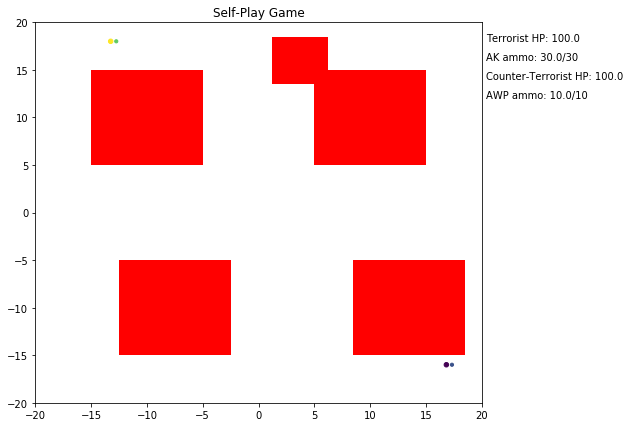

In [169]:
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import clear_output
from matplotlib import animation, rc
from IPython.display import HTML
import time
rc('animation', html='jshtml')

offsets, colors, ammo, Map, PPO_data = simulate_game(fmodel, gmodel, hmodel, tnodes=0, ctnodes=0, frames=155, verbose=True)
frames = int(len(PPO_data[1])/2)
interval = frames
#offsets = np.array(offsets)
#colors = np.array(colors)
fig, ax = plt.subplots(figsize=(10, 7))
ax.set_xlim((-Map.size, Map.size))
ax.set_ylim((-Map.size, Map.size))

for box in Map.boxes:
    rect = plt.Rectangle((box.x - box.size/2, box.y - box.size/2), box.size, box.size, fc="red")
    plt.gca().add_patch(rect)



box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height]) # Shrink current axis by 20%
counts = [ax.text(1.01, 0.95-i*0.05,  '', transform=ax.transAxes) for i in range(4)]
scat = plt.scatter(np.zeros(4), np.zeros(4), c=[200, 0, 150, 50], s=[20, 20, 10, 10])
plt.title("Self-Play Game") 
anim = animation.FuncAnimation(fig, update_plot, frames=frames,
                              fargs=(offsets, colors, ammo, scat), interval=interval)

In [168]:
anim

In [12]:
# Set up formatting for the movie files
Writer = animation.writers['ffmpeg']
writer = Writer(fps=4.0, metadata=dict(artist='Me'), bitrate=1800)
anim.save('selfplay.mp4', writer=writer)


NameError: name 'animation' is not defined